# **CI Course - EX10**

--------

--------


## Theory Overview ##

**What is CNN (Convolutional Neural Networks) ??**

Convolutional Neural Networks are a type of deep learning algorithm designed mainly for analyzing visual data, such as images or videos.CNNs are composed of multiple layers, with the convolutional layers being the core components. **Convolutional layers apply filters or feature detectors** to input images, **capturing important patterns and features** in a hierarchical manner. 

**Unlike fully connected** layers, which **connect every neuron to every neuron** in the previous layer, **convolutional layers have sparse connectivity**. This means that each neuron in a convolutional layer only receives input from a small region of the previous layer, **reducing the number of parameters and enabling the network to scale efficiently**. This is a **significant difference** between CNNs and fully connected layers.

Two main advantages of CNNs are:

1. Local feature learning: Convolutional layers capture local patterns and features in images, allowing the network to learn hierarchical representations. This enables CNNs to automatically extract relevant features from raw data, making them effective for tasks like image classification and object detection.

2. Translation invariance: CNNs are able to recognize patterns regardless of their position in an image. This property, known as translation invariance, allows CNNs to robustly identify objects even if they appear in different locations within an image. This makes CNNs well-suited for tasks involving object recognition and localization.

Two widely known applications of CNNs include image classification and object detection, although there are numerous other applications where CNNs have proven to be effective.

**The convolution operation**

So we said that convolutional layers apply filters, what are they??

The filters in CNN layers are small matrices or grids of numbers.This filters slide over the image, pixel by pixel, performing a mathematical operation called convolution. The convolution operation combines the values of the filter and the corresponding pixels in the image, producing a new value.

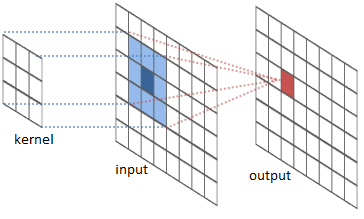

To illustrate, if we have a 3x3 filter matrix and a 4x4 input, the filter would be applied by sliding it over the input as follow:

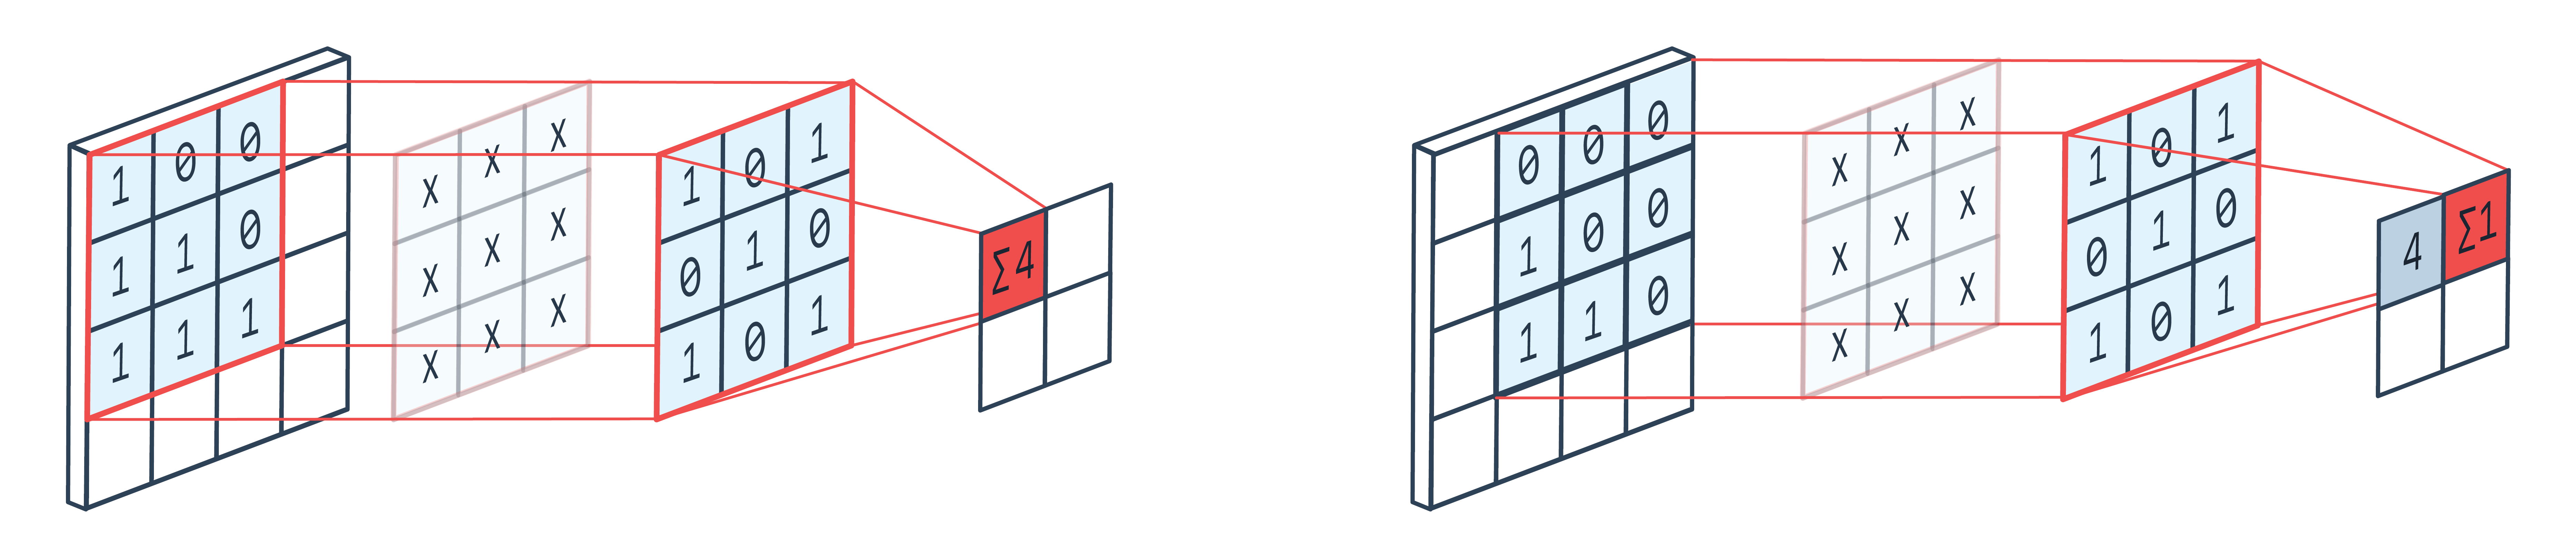


**Alright, what is the next step? How should we proceed from here?**

After CNN layers, the next steps of a neural network typically involve additional layers to further process the extracted features. This often includes fully connected layers enabling the network to learn complex relationships and make predictions based on the extracted features.

---

### Exercise - Image Classification - CIFAR Dataset ###

What is the CIFAR dataset? 

The CIFAR dataset is a popular benchmark dataset commonly used for training and evaluating machine learning models, particularly for image classification tasks. CIFAR stands for the Canadian Institute for Advanced Research, which originally created the dataset.

There are two main versions of the CIFAR dataset: CIFAR-10 and CIFAR-100.

**Input:**

For CIFAR-10, the inputs are **RGB (color) images with a fixed size of 32x32** pixels. Each image is represented as a **3-dimensional array with dimensions (32, 32, 3), where 3 corresponds to the three color channels (red, green, and blue)**.

**Output:**

The CIFAR-10 dataset consists of **10 different classes**, including common objects such as airplanes, cars, cats, dogs, and more. Each image in the dataset is assigned a corresponding label indicating its class.




---

## Solution ##

**Solution flow:**

0. Imports
1. Set Hyperparameters
2. Load and pre-process
3. Build the model
4. Set optimizer & loss function
5. Training loop and learning curves
6. Evaluate

----

### Imports ###

In this exercise, we will utilize the torchvision library, which is a valuable PyTorch library.

torchvision containing computer vision-related utilities. It provides access to popular datasets, model architectures, and commonly used image transformations for computer vision. It makes it easy to load and preprocess data for training and evaluation of deep learning models for computer vision tasks.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# welcome torchvision
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns #not necessary for the training , only for visualising the confusion matrix
%matplotlib qt 


---

### Set hyperparameters ###

In [2]:
epochs = 5
batch_size = 12
lr =0.005
momentum = 0.9

torch.random.manual_seed(42)

PATH = './cifar_net.pth' # for saving the model

---

### Loading and Pre-process ###

**Pre-process**

In this exercise the pre-process steps will be implemented by torchvision transforms module.

**transforms** is a module within the torchvision package that provides common transformations. These transformations can be used to preprocess data before feeding it into a neural network.

```transforms.ToTensor()``` - Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

```transforms.Normalize()``` - Normalizing input by given mean and std. does the following for each channel of the input. 

$$ x_{normalized} = {{(x - \mu)} \over {\sigma}} $$



In [3]:
transform = transforms.Compose([transforms.ToTensor(),  
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# image_input(HXWXC,[0,255])>>ToTensor(image_input)>>image_tensor((CxHxW),[0,1])>>Normalize(image_tensor)
# >>image_tensor((CxHxW),[-1,1])

**Loading the data (using pytorch DataLoader)**

In PyTorch, loading a dataset involves **creating an instance of a dataset object** and passing it to a DataLoader. The dataset object can be a custom dataset that you define, or one of the many built-in datasets provided by the torchvision, torchaudio, and torchtext packages. **These built-in datasets automatically download and preprocess the data**, making it easy to get started with training machine learning models. Once you have created an instance of the dataset, **you can pass it to a DataLoader along with some additional parameters such as the batch size and whether the data should be shuffled. The DataLoader returns an iterator that yields batches of data**, which can be easily iterated over in a training loop to feed batches of data into the model.

```torchvision.datasets``` - creating a dataset instance


```torch.utils.data.DataLoader``` - creating a dataloader object


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))

frog  plane deer  car   bird  horse truck deer  horse ship  deer  dog  


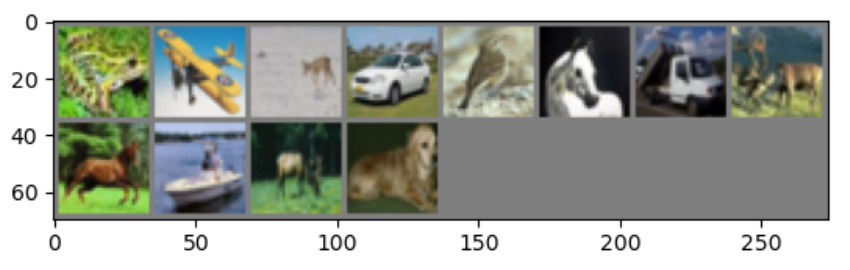

----

### Build the model ###

So, today our classifier model is going to consist **2 convolutional layers** each of them activated by **Relu** and after that downsample using **pooling layer**. 

**what is pooling layer??**

Pooling layers in neural networks are used to downsample the input data by aggregating neighboring values, reducing the spatial dimensions while preserving important features.

To illustrate, let's consider the utilization of a max pooling layer today:

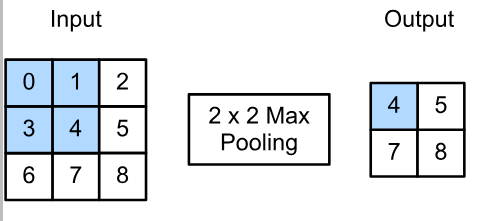

Following the CNN step, we will proceed with **3 consecutive fully connected layers**. Finally, for the output layer, we will apply the **softmax activation function** (more information - see EX9).

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) #(in channels, out channels, kernel size)
        self.pool = nn.MaxPool2d(2, 2) #(kernel size, strid step)
        self.conv2 = nn.Conv2d(16, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, len(classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(-1, x) # flatten all dimensions except batch
        x = x.view(-1,24*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.softmax(x)
        return x

net = Net()
net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

To summarize, our network architecture can be visualized as follows:

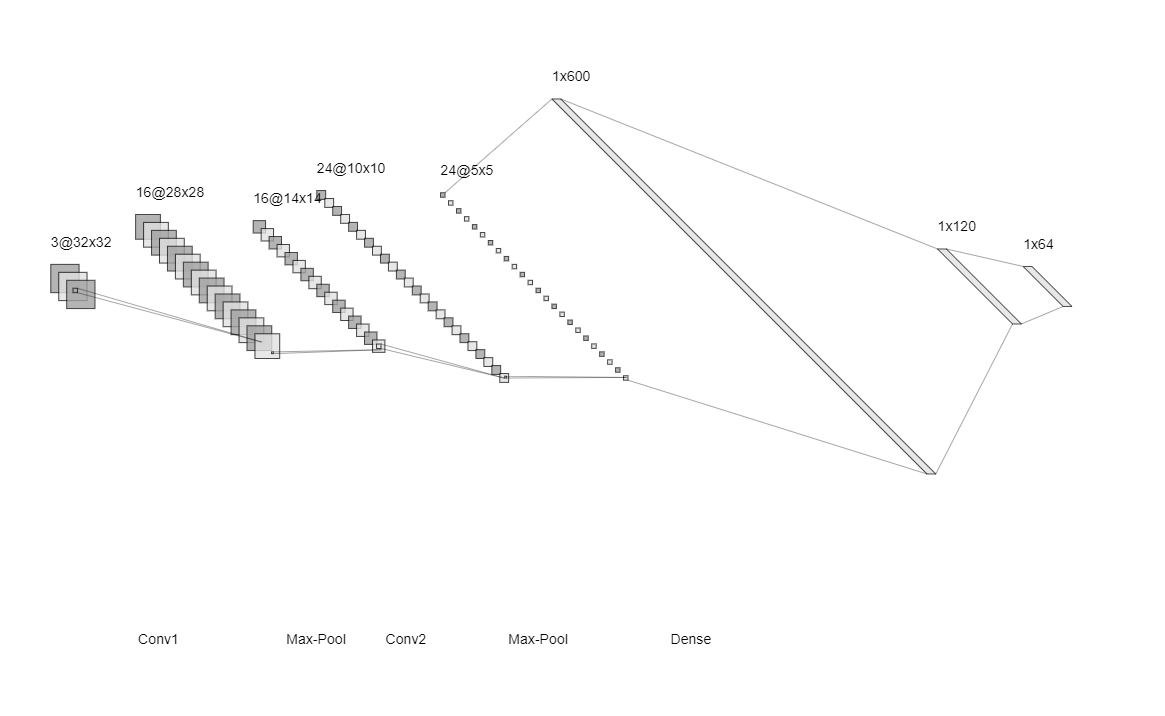

----

### Set optimizer and loss function ###

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

----

### Training loop ###

In [8]:
net.train()
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # back prop
        loss.backward()
        #update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 1.781
[1,  4000] loss: 1.424
[2,  2000] loss: 1.239
[2,  4000] loss: 1.175
[3,  2000] loss: 1.067
[3,  4000] loss: 1.051
[4,  2000] loss: 0.963
[4,  4000] loss: 0.965
[5,  2000] loss: 0.896
[5,  4000] loss: 0.902
Finished Training


**Now lets save the model so we can use it later!**

In [9]:
torch.save(net.state_dict(), PATH) 

-----

### Evaluate ###

Now we can load our saved model and evaluate it! 

In [10]:
net2 = Net()
net2.load_state_dict(torch.load(PATH))
net2.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [11]:
correct = 0
total = 0
with torch.no_grad(): # Since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

# print images
imshow(torchvision.utils.make_grid(images))

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck
Predicted:  cat   ship  ship  ship  deer  frog  car   frog  cat   car   plane truck


### Confusion matrix #### 

**what is confusion matrix?**

A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of true positives, false positives, true negatives, and false negatives for each class. The rows represent the true class labels, while the columns represent the predicted class labels. Diagonal entries represent correct classifications, while off-diagonal entries represent misclassifications. A confusion matrix can be used to calculate performance metrics such as accuracy, precision, recall, and F1-score.


In [13]:
# Get the predicted labels for the test data
predicted_labels = []
for images, labels in testloader:
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.tolist())

# Get the true labels for the test data
true_labels = testset.targets

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix

sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2%')
plt.show()


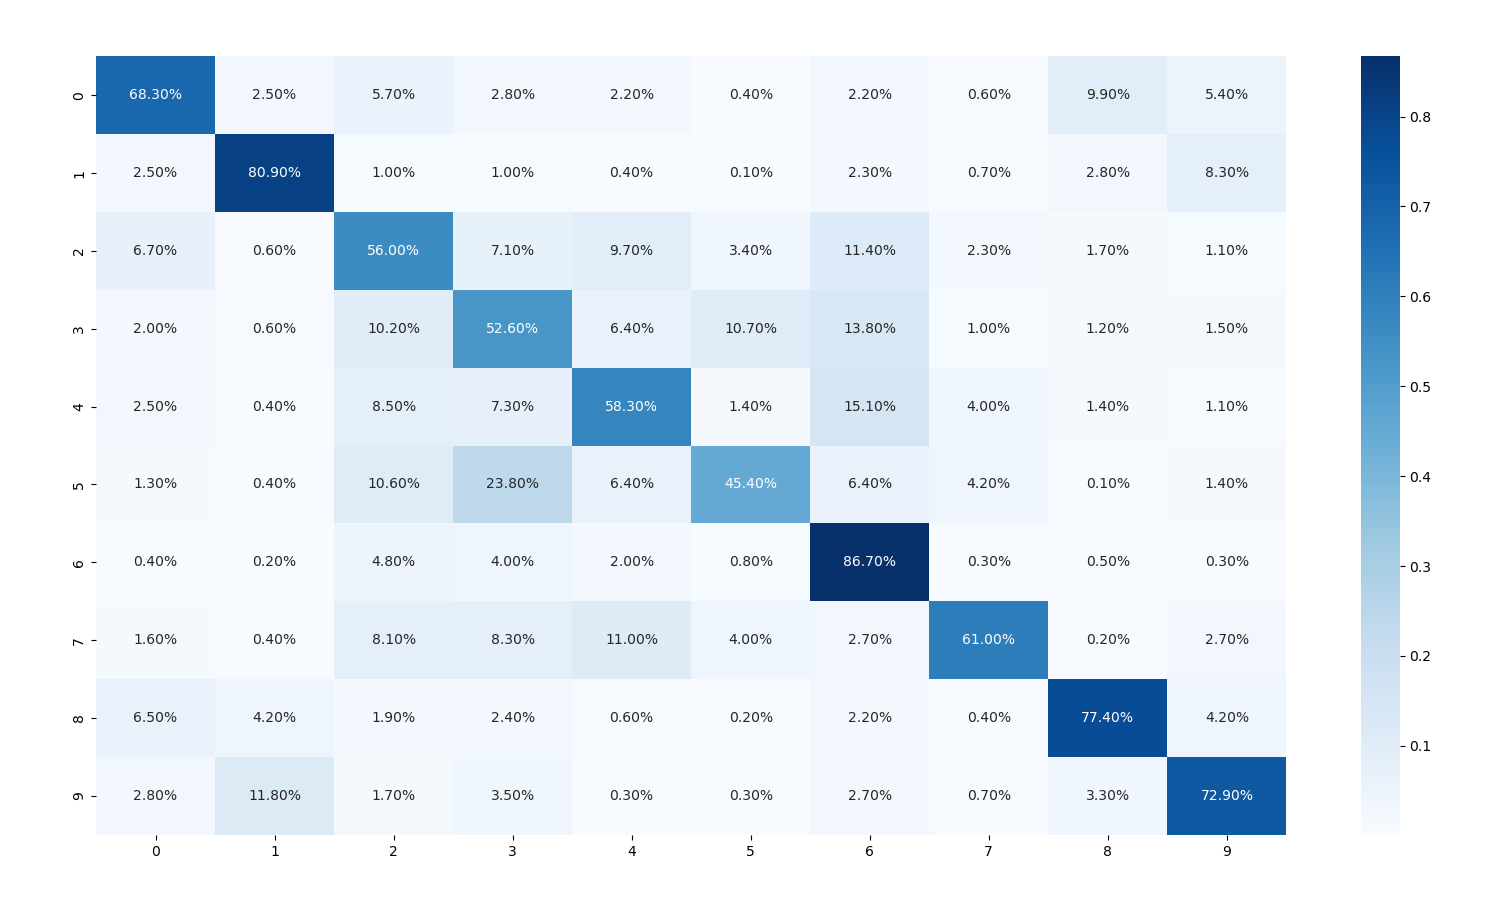

---

## Summary ##

In this exercise we covered:

1. CNN - briefly
2. Implement CNN classifier on CIFAR10 dataset using pytorch

Keep in progress!!

---

## Helpful and extra links ##

1. [Convolutional Neural Networks, Explained #1](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939)
2. [Convolutional Neural Networks, Explained #2](https://www.youtube.com/watch?v=YRhxdVk_sIs)
3. [Building a Convolutional Neural Network in PyTorch #1](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/)
4. [Building a Convolutional Neural Network in PyTorch #2](https://www.youtube.com/watch?v=pDdP0TFzsoQ)
---